# Heart Disease Risk Prediction: Logistic Regression

## Step 1: Load and Prepare the Dataset

**Data Source:** Heart Disease Dataset downloaded from Kaggle (https://www.kaggle.com/datasets/neurocipher/heartdisease).

The dataset contains 270 patient records with 14 clinical features and a binary target (Presence/Absence of heart disease).

In [1]:
%pip install numpy matplotlib pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

# Load the dataset
df = pd.read_csv('Heart_Disease_Prediction.csv')
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn names and types:")
print(df.dtypes)

Dataset shape: (270, 14)

First few rows:
   Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   70    1                4  130          322             0            2   
1   67    0                3  115          564             0            2   
2   57    1                2  124          261             0            0   
3   64    1                4  128          263             0            0   
4   74    0                2  120          269             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     109                0            2.4            2   
1     160                0            1.6            2   
2     141                0            0.3            1   
3     105                1            0.2            2   
4     121                1            0.2            1   

   Number of vessels fluro  Thallium Heart Disease  
0                        3         3      Presence  
1                        0         7    

### 1.1 Exploratory Data Analysis (EDA)

In [3]:
# Basic statistics
print("Basic statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

Basic statistics:
              Age         Sex  Chest pain type          BP  Cholesterol  \
count  270.000000  270.000000       270.000000  270.000000   270.000000   
mean    54.433333    0.677778         3.174074  131.344444   249.659259   
std      9.109067    0.468195         0.950090   17.861608    51.686237   
min     29.000000    0.000000         1.000000   94.000000   126.000000   
25%     48.000000    0.000000         3.000000  120.000000   213.000000   
50%     55.000000    1.000000         3.000000  130.000000   245.000000   
75%     61.000000    1.000000         4.000000  140.000000   280.000000   
max     77.000000    1.000000         4.000000  200.000000   564.000000   

       FBS over 120  EKG results      Max HR  Exercise angina  ST depression  \
count    270.000000   270.000000  270.000000       270.000000      270.00000   
mean       0.148148     1.022222  149.677778         0.329630        1.05000   
std        0.355906     0.997891   23.165717         0.470952     

Target distribution:
Target
0    150
1    120
Name: count, dtype: int64

Disease rate: 44.4%


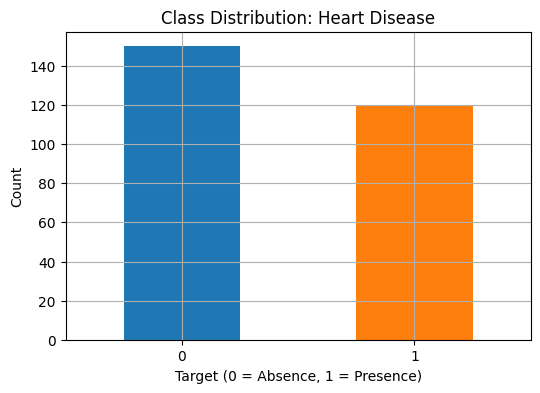

In [4]:
# Binarize target: 1 = Presence (disease), 0 = Absence (no disease)
df['Target'] = (df['Heart Disease'] == 'Presence').astype(int)

print("Target distribution:")
print(df['Target'].value_counts())
print(f"\nDisease rate: {df['Target'].mean()*100:.1f}%")

# Plot class distribution
plt.figure()
df['Target'].value_counts().plot(kind='bar', color=['tab:blue', 'tab:orange'])
plt.title("Class Distribution: Heart Disease")
plt.xlabel("Target (0 = Absence, 1 = Presence)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

### 1.2 Feature Selection and Preprocessing

We select 6 key clinical features:
- **Age**: Patient age in years
- **BP**: Resting blood pressure (mm Hg)
- **Cholesterol**: Serum cholesterol (mg/dl)
- **Max HR**: Maximum heart rate achieved
- **ST depression**: ST depression induced by exercise
- **Number of vessels fluro**: Number of major vessels (0-3)

In [5]:
# Select features for the model
selected_features = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression', 'Number of vessels fluro']

X = df[selected_features].values
y = df['Target'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nSelected features: {selected_features}")

Feature matrix shape: (270, 6)
Target vector shape: (270,)

Selected features: ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression', 'Number of vessels fluro']


In [6]:
# Stratified train/test split (70/30)
np.random.seed(42)

# Get indices for each class
idx_class_0 = np.where(y == 0)[0]
idx_class_1 = np.where(y == 1)[0]

# Shuffle indices
np.random.shuffle(idx_class_0)
np.random.shuffle(idx_class_1)

# Calculate split sizes for each class (30% test)
n_test_0 = int(len(idx_class_0) * 0.3)
n_test_1 = int(len(idx_class_1) * 0.3)

# Split indices
test_idx = np.concatenate([idx_class_0[:n_test_0], idx_class_1[:n_test_1]])
train_idx = np.concatenate([idx_class_0[n_test_0:], idx_class_1[n_test_1:]])

# Shuffle train and test indices
np.random.shuffle(train_idx)
np.random.shuffle(test_idx)

# Create train and test sets
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution: {np.mean(y_train)*100:.1f}% disease")
print(f"Test set class distribution: {np.mean(y_test)*100:.1f}% disease")

Training set: 189 samples
Test set: 81 samples

Training set class distribution: 44.4% disease
Test set class distribution: 44.4% disease


In [7]:
# Feature normalization (z-score)
# Compute mean and std from training set only (avoid data leakage)
mu = np.mean(X_train, axis=0)
sigma = np.std(X_train, axis=0)

# Normalize both sets using training statistics
X_train_norm = (X_train - mu) / sigma
X_test_norm = (X_test - mu) / sigma

print("Normalization statistics (from training set):")
print(f"{'Feature':<25} {'Mean':>10} {'Std':>10}")
print("-" * 47)
for i, feat in enumerate(selected_features):
    print(f"{feat:<25} {mu[i]:>10.2f} {sigma[i]:>10.2f}")

print(f"\nNormalized training set mean: {np.mean(X_train_norm, axis=0).round(4)}")
print(f"Normalized training set std: {np.std(X_train_norm, axis=0).round(4)}")

Normalization statistics (from training set):
Feature                         Mean        Std
-----------------------------------------------
Age                            54.58       9.29
BP                            131.65      18.42
Cholesterol                   256.22      52.76
Max HR                        149.13      23.37
ST depression                   1.04       1.13
Number of vessels fluro         0.68       0.97

Normalized training set mean: [-0.  0. -0. -0.  0. -0.]
Normalized training set std: [1. 1. 1. 1. 1. 1.]


## Step 2: Implement Basic Logistic Regression

We implement logistic regression from scratch.

The **hypothesis** (model) is:
$$
f_{\vec{w}, b}(\vec{x}) = \sigma(\vec{w} \cdot \vec{x} + b)
$$

where the **sigmoid** function is:
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

The **cost function** (binary cross-entropy) is:
$$
J(\vec{w}, b) =
-\frac{1}{m}
\sum_{i=1}^m
\left[
y^{(i)} \log f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)})
+
(1 - y^{(i)}) \log\big(1 - f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)})\big)
\right]
$$

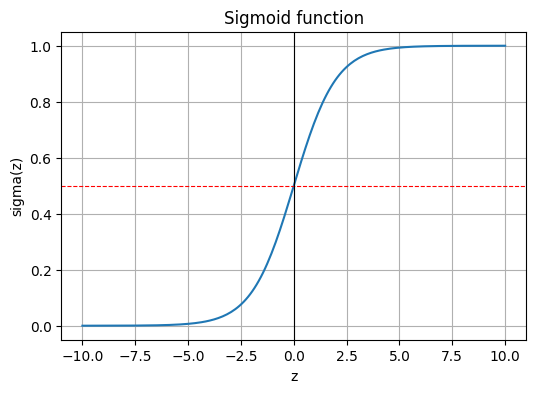

In [8]:
def sigmoid(z):
    """Compute the sigmoid of z."""
    return 1 / (1 + np.exp(-z))


# Visualize the sigmoid function
z_values = np.linspace(-10, 10, 200)
sig_values = sigmoid(z_values)

plt.figure()
plt.plot(z_values, sig_values)
plt.title("Sigmoid function")
plt.xlabel("z")
plt.ylabel("sigma(z)")
plt.ylim(-0.05, 1.05)
plt.axhline(0.5, color="red", linestyle="--", linewidth=0.8)
plt.axvline(0, color="black", linewidth=0.8)
plt.show()

In [9]:
def compute_cost(w, b, X, y):
    """Compute logistic regression cost J(w, b)."""
    m, n = X.shape

    # f_{w,b}^{(i)}(x^{(i)}) = sigmoid(w · x^{(i)} + b)
    z = X @ w + b
    f = sigmoid(z)

    # To avoid log(0), clip probabilities
    eps = 1e-8
    f_clipped = np.clip(f, eps, 1 - eps)

    J = -(1 / m) * np.sum(
        y * np.log(f_clipped) + (1 - y) * np.log(1 - f_clipped)
    )
    return J


# Test with zero parameters
w_test = np.zeros(X_train_norm.shape[1])
b_test = 0.0
J_test = compute_cost(w_test, b_test, X_train_norm, y_train)
print(f"Cost with zero parameters: J = {J_test:.4f}")
print(f"Expected (for balanced classes): -ln(0.5) = {-np.log(0.5):.4f}")

Cost with zero parameters: J = 0.6931
Expected (for balanced classes): -ln(0.5) = 0.6931


### 2.1 Gradients of the Cost Function

The gradients are:

For each weight $w_j$:
$$
\frac{\partial J}{\partial w_j}
=
\frac{1}{m}
\sum_{i=1}^m
\left(
f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) - y^{(i)}
\right)
x^{(i)}_j
$$

For the bias:
$$
\frac{\partial J}{\partial b}
=
\frac{1}{m}
\sum_{i=1}^m
\left(
f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) - y^{(i)}
\right)
$$

In [10]:
def compute_gradient(w, b, X, y):
    """Compute gradients dJ/dw and dJ/db."""
    m, n = X.shape

    # f_{w,b}^{(i)}(x^{(i)})
    z = X @ w + b
    f = sigmoid(z)

    error = f - y  # e^{(i)} = f_{w,b}^{(i)}(x^{(i)}) - y^{(i)}

    dj_dw = (1 / m) * (X.T @ error)
    dj_db = (1 / m) * np.sum(error)

    return dj_dw, dj_db


# Test gradient computation
dj_dw_test, dj_db_test = compute_gradient(w_test, b_test, X_train_norm, y_train)
print(f"Gradient at zero parameters:")
print(f"dJ/dw = {dj_dw_test}")
print(f"dJ/db = {dj_db_test:.4f}")

Gradient at zero parameters:
dJ/dw = [-0.1355447  -0.14098074 -0.0828104   0.21599968 -0.21803207 -0.21911117]
dJ/db = 0.0556


### 2.2 Gradient Descent

Gradient descent updates parameters:
$$
w_j := w_j - \alpha \frac{\partial J}{\partial w_j}, \quad
b := b - \alpha \frac{\partial J}{\partial b}
$$

where $\alpha > 0$ is the **learning rate**.

In [11]:
def gradient_descent(X, y, w_init, b_init, alpha, num_iters, print_every=0):
    """Run gradient descent to optimize w and b."""
    w = w_init.copy()
    b = b_init
    J_history = []

    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient(w, b, X, y)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        J = compute_cost(w, b, X, y)
        J_history.append(J)

        if print_every > 0 and (i % print_every == 0 or i == num_iters - 1):
            print(f"Iteration {i:4d}: J(w, b) = {J:.4f}")

    return w, b, J_history

In [12]:
# Train logistic regression
n_features = X_train_norm.shape[1]
w0 = np.zeros(n_features)
b0 = 0.0

alpha = 0.01
num_iters = 1000

w_trained, b_trained, J_hist = gradient_descent(
    X_train_norm, y_train, w0, b0, alpha, num_iters, print_every=200
)

print(f"\nFinal parameters:")
print(f"w = {w_trained}")
print(f"b = {b_trained:.4f}")

Iteration    0: J(w, b) = 0.6912
Iteration  200: J(w, b) = 0.5174
Iteration  400: J(w, b) = 0.4741
Iteration  600: J(w, b) = 0.4561
Iteration  800: J(w, b) = 0.4465
Iteration  999: J(w, b) = 0.4407

Final parameters:
w = [ 0.06588571  0.41773347  0.17972803 -0.6336913   0.69155559  0.70491681]
b = -0.1934


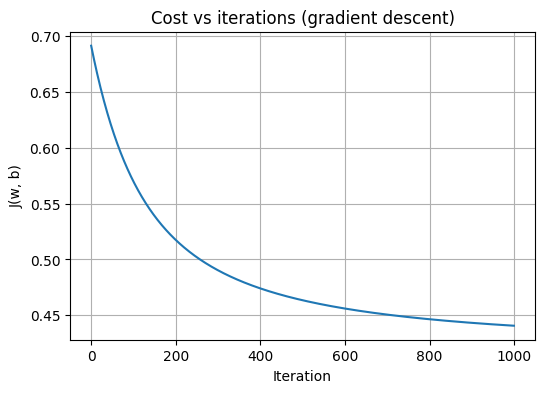

In [13]:
# Plot cost vs iterations
plt.figure()
plt.plot(J_hist)
plt.title("Cost vs iterations (gradient descent)")
plt.xlabel("Iteration")
plt.ylabel("J(w, b)")
plt.show()

### 2.3 Prediction and Evaluation

Prediction rule:
$$
\hat{y} =
\begin{cases}
1 & \text{if } f_{\vec{w}, b}(\vec{x}) \ge 0.5 \\
0 & \text{otherwise}
\end{cases}
$$

In [14]:
def predict(w, b, X, threshold=0.5):
    """Predict class labels using threshold."""
    z = X @ w + b
    f = sigmoid(z)
    return (f >= threshold).astype(int)


def compute_metrics(y_true, y_pred):
    """Compute accuracy, precision, recall, and F1 score."""
    # True positives, false positives, true negatives, false negatives
    TP = np.sum((y_pred == 1) & (y_true == 1))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    TN = np.sum((y_pred == 0) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return accuracy, precision, recall, f1

In [15]:
# Predictions on train and test sets
y_train_pred = predict(w_trained, b_trained, X_train_norm)
y_test_pred = predict(w_trained, b_trained, X_test_norm)

# Compute metrics
train_acc, train_prec, train_rec, train_f1 = compute_metrics(y_train, y_train_pred)
test_acc, test_prec, test_rec, test_f1 = compute_metrics(y_test, y_test_pred)

# Display metrics table
print("=" * 50)
print("EVALUATION METRICS")
print("=" * 50)
print(f"{'Metric':<15} {'Train':>15} {'Test':>15}")
print("-" * 50)
print(f"{'Accuracy':<15} {train_acc:>15.4f} {test_acc:>15.4f}")
print(f"{'Precision':<15} {train_prec:>15.4f} {test_prec:>15.4f}")
print(f"{'Recall':<15} {train_rec:>15.4f} {test_rec:>15.4f}")
print(f"{'F1 Score':<15} {train_f1:>15.4f} {test_f1:>15.4f}")
print("=" * 50)

EVALUATION METRICS
Metric                    Train            Test
--------------------------------------------------
Accuracy                 0.7778          0.7160
Precision                0.7917          0.7241
Recall                   0.6786          0.5833
F1 Score                 0.7308          0.6462


In [16]:
# Interpretation of learned coefficients
print("Learned coefficients interpretation:")
print("-" * 50)
for i, feat in enumerate(selected_features):
    sign = "+" if w_trained[i] > 0 else "-"
    print(f"{feat:<25}: w = {w_trained[i]:>8.4f} ({sign} risk)")
print(f"{'Bias (b)':<25}: {b_trained:>8.4f}")

Learned coefficients interpretation:
--------------------------------------------------
Age                      : w =   0.0659 (+ risk)
BP                       : w =   0.4177 (+ risk)
Cholesterol              : w =   0.1797 (+ risk)
Max HR                   : w =  -0.6337 (- risk)
ST depression            : w =   0.6916 (+ risk)
Number of vessels fluro  : w =   0.7049 (+ risk)
Bias (b)                 :  -0.1934
